In [105]:
import os, io
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageOps
import numpy as np
import cupy as cp
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import sqlite3

from utils import *

In [3]:
config = Config('VER_2')
RNG = np.random.default_rng()

device_marker = cp.empty(1)
xp = cp.get_array_module(device_marker)

In [128]:
def clear_dataset_folder():
    if not os.path.exists(config.dataset_path):
        print(f'Creating "{config.dataset_path}"')
        os.mkdir(config.dataset_path)
    else:
        print(f'Cleaning "{config.dataset_path}"')
        removed = 0
        
        for fn in os.listdir(config.dataset_path):
            if fn.endswith(".db"):
                os.remove(os.path.join(config.dataset_path, fn))
                removed += 1

        print(f'Removed {removed} .db files')

In [5]:
dataset_source = os.path.join(config.dataset_source)

In [6]:
import struct
from array import array

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        
        images = []
        
        # for i in range(size):
        #     images.append([0] * rows * cols)
            
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images.append(img)
        
        return np.array(images), np.array(labels)
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)     

CPU times: user 176 ms, sys: 111 ms, total: 287 ms
Wall time: 301 ms


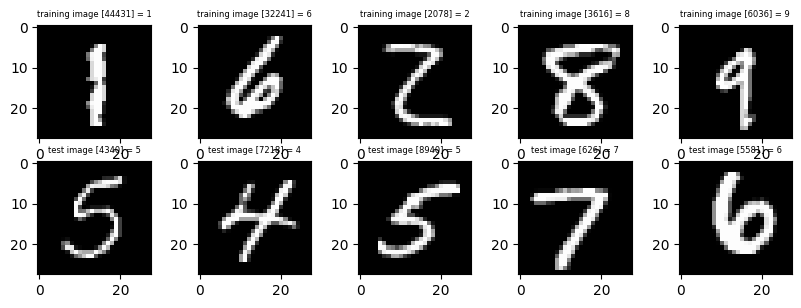

In [7]:
%%time
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
training_images_filepath = os.path.join(dataset_source, 'train-images-idx3-ubyte')
training_labels_filepath = os.path.join(dataset_source, 'train-labels-idx1-ubyte')
test_images_filepath = os.path.join(dataset_source, 't10k-images-idx3-ubyte')
test_labels_filepath = os.path.join(dataset_source, 't10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,5))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 6);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 5):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [8]:
SENSOR_RECEPTIVE_FIELD_SIZE = 8
SENSOR_RECEPTIVE_FIELD_SQUARE = SENSOR_RECEPTIVE_FIELD_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
SENSOR_GROUP_SIZE = 4
SENSOR_GROUP_SQUARE = SENSOR_GROUP_SIZE * SENSOR_GROUP_SIZE
RETINA_SIZE = 16
RETINA_SQUARE = RETINA_SIZE * RETINA_SIZE


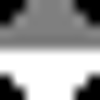
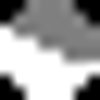
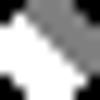
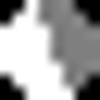
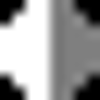
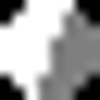
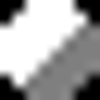
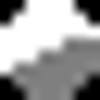
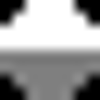
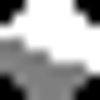
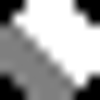
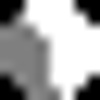
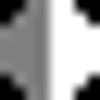
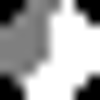
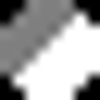
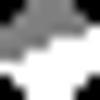

In [9]:
group_sensors_img = []
captions = []
steps = pow(SENSOR_GROUP_SIZE, 2)
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    draw.ellipse([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], outline=0, fill=127, width=0)
    angle = i * 360 / steps
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    group_sensors_img.append(canvas)
    captions.append(f'#{i} ({i // SENSOR_GROUP_SIZE}, {i % SENSOR_GROUP_SIZE})')

display_images_grid(list(map(lambda x: x.crop([0,0,SENSOR_RECEPTIVE_FIELD_SIZE,SENSOR_RECEPTIVE_FIELD_SIZE]).resize((100, 100)), group_sensors_img)), col_count=SENSOR_GROUP_SIZE, captions=captions)

In [10]:
group_sensors = xp.array(list(map(xp.array, group_sensors_img))).astype(float)
shape_save = group_sensors.shape
group_sensors = group_sensors.reshape(SENSOR_GROUP_SIZE*SENSOR_GROUP_SIZE, -1)
# Due to rough granularity count of positive pixels and negative may be not eqaul => equalize via weight
group_sensors[group_sensors==255] = 1
counts_of_positives = (group_sensors == 1).sum(axis=1)
counts_of_negatives = (group_sensors == 127).sum(axis=1)
white_image = xp.ones(group_sensors.shape[1])

for i, (p, n) in enumerate(zip(counts_of_positives, counts_of_negatives)):
    assert p > 0, (i, p)
    assert n > 0, (i, n)
    group_sensors[i][group_sensors[i] == 127] = -1 * (p / n)
    v = group_sensors[i] @ white_image
    assert xp.isclose(v, 0), v

group_sensors = group_sensors.reshape(shape_save)
group_sensors.shape, np.unique_counts(group_sensors.get())

((16, 128, 128),
 UniqueCountsResult(values=array([-1.36363636, -1.26086957, -1.16666667, -1.08      , -1.        ,
         0.        ,  1.        ]), counts=array([    44,    138,     48,     50,    104, 261312,    448])))

In [11]:
group_sensors_ones = (group_sensors.reshape(group_sensors.shape[0], -1) == 1).sum(axis=1)
group_sensors_ones, group_sensors_ones.mean(), group_sensors_ones.min(), group_sensors_ones.max(), group_sensors_ones.std()

(array([26, 27, 29, 28, 26, 28, 29, 27, 26, 29, 29, 30, 26, 30, 29, 29]),
 array(28.),
 array(26),
 array(30),
 array(1.41421356))


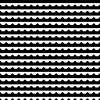
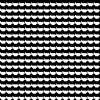
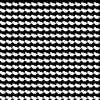
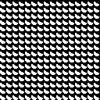
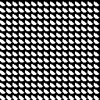
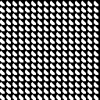
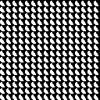
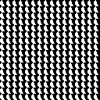
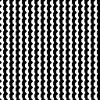
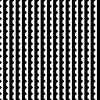
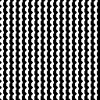
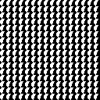
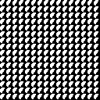
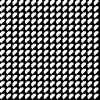
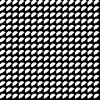
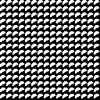
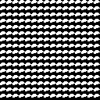
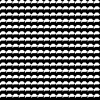
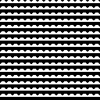
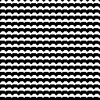
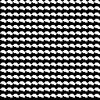
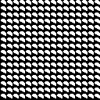
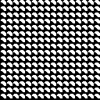
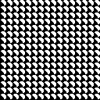
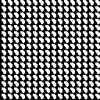
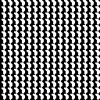
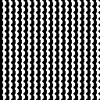
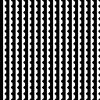
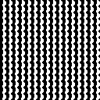
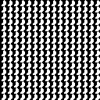
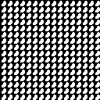
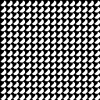
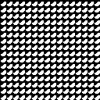
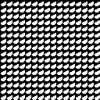
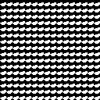
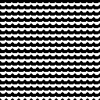

In [12]:
sz = RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE
steps = 36 # 10 degreee
specific_samples_img = []
captions = []

for i in range(steps):
    canvas = Image.new('L', (sz, sz))
    draw = ImageDraw.Draw(canvas)
    angle = i * 360 / steps
       
    draw.chord([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE - 1, SENSOR_RECEPTIVE_FIELD_SIZE - 1], angle, angle + 180, outline=255, fill=255)
    crop = canvas.crop([0, 0, SENSOR_RECEPTIVE_FIELD_SIZE, SENSOR_RECEPTIVE_FIELD_SIZE])

    for x in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
        for y in range(0, sz, SENSOR_RECEPTIVE_FIELD_SIZE):
            canvas.paste(crop, [x, y, x + SENSOR_RECEPTIVE_FIELD_SIZE, y + SENSOR_RECEPTIVE_FIELD_SIZE])
            
    specific_samples_img.append(canvas)
    captions.append(f'#{i}')

display_images_grid(list(map(lambda x: x.resize((100, 100)), specific_samples_img)), col_count=int(np.sqrt(steps)), captions=captions)

In [13]:
SPECIFIC_SAMPLES = np.array(list(map(np.array, specific_samples_img))).astype(float)
SPECIFIC_SAMPLES[SPECIFIC_SAMPLES==255] = 1
SPECIFIC_SAMPLES = SPECIFIC_SAMPLES.reshape(SPECIFIC_SAMPLES.shape[0], -1)
SPECIFIC_SAMPLES.shape, np.unique_counts(SPECIFIC_SAMPLES)

((36, 16384),
 UniqueCountsResult(values=array([0., 1.]), counts=array([331776, 258048])))

In [14]:
# single sensor occupies (RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE) ^ 2
# we have group of such sensors stacked under each other in a square fashion, hence SENSOR_GROUP_SIZE^2
# to cover all visual area we have RETINA_SIZE^2 of such groups
retina = xp.zeros((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
retina = retina.reshape((RETINA_SIZE, RETINA_SIZE, pow(SENSOR_GROUP_SIZE, 2), -1))

for y in range(RETINA_SIZE):
    for x in range(RETINA_SIZE):
        for g in range(pow(SENSOR_GROUP_SIZE, 2)):
            sensor_at_place = group_sensors[g]
            sensor_at_place = xp.roll(sensor_at_place, y * SENSOR_RECEPTIVE_FIELD_SIZE, axis=0)
            sensor_at_place = xp.roll(sensor_at_place, x * SENSOR_RECEPTIVE_FIELD_SIZE, axis=1)
            retina[y, x, g, :] = sensor_at_place.reshape(-1)

retina = retina.reshape((-1, pow(RETINA_SIZE * SENSOR_RECEPTIVE_FIELD_SIZE, 2)))
RETINA_POS = retina
RETINA_NEG = retina.copy()

RETINA_POS[RETINA_POS < 0] = 0
RETINA_NEG[RETINA_NEG > 0] = 0

In [15]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image

In [16]:
MINIMAL_ILLUMINATION_ABS_LEVEL = 255 * 0.1
MINIMAL_ILLUMINATION_DIFF_DB = 2 # dB
MINIMAL_ILLUMINATION_DIFF_RATIO = pow(10, MINIMAL_ILLUMINATION_DIFF_DB/20)

def sense_images(images, active_sensors=None):
    active_sensors = xp.ones((RETINA_SQUARE * SENSOR_GROUP_SQUARE, 1)) if active_sensors is None else active_sensors
    assert active_sensors.shape == (RETINA_POS.shape[0], 1)
    sense_ress = []
    image_masks = images.copy()
    image_masks[image_masks > 0] = 1

    effective_retina_pos = RETINA_POS * active_sensors
    effective_retina_neg = RETINA_NEG * active_sensors
    sense_area = (effective_retina_pos @ image_masks.T).T # for check of illuminated area
    sense_level = (effective_retina_pos @ images.T).T # for check of absolute illumination
    sense_neg_level = (effective_retina_neg @ images.T).T # for check of relative diff

    assert sense_area.shape == (len(images), RETINA_SQUARE * SENSOR_GROUP_SQUARE), sense_area.shape
    assert sense_area.shape == sense_level.shape
    assert sense_area.shape == sense_neg_level.shape
    
    # Base for calculations = AREA of illumination must be at least 1/2 of area of positive receptors
    # Next we exclude sensors which do not minimal LEVEL of illumination = area * (255 * 10%)
    # Finally we exclude sensors which do not have enough contrast (DIFF) - use NEG part of retina and use logarithmic scale (dB)
    for sense_area_i, sense_level_i, sense_neg_level_i in zip(sense_area, sense_level, sense_neg_level):
        sense_area_i = sense_area_i.reshape(-1, 16)
        cond1 = (sense_area_i / group_sensors_ones) >= 0.5 # At least half of a positive area of each of sensors is activated
        cond1 = cond1.reshape(-1,)
    
        sense_level_i = sense_level_i.reshape(-1, 16)
        sense_level_i[sense_level_i <= 0] = 1e-6 # to ease cond3
        cond2 = (sense_level_i > MINIMAL_ILLUMINATION_ABS_LEVEL * group_sensors_ones) # Illumination level of an area must exceed given threshold
        cond2 = cond2.reshape(-1,)
    
        sense_neg_level_i = xp.abs(sense_neg_level_i)
        sense_neg_level_i[sense_neg_level_i <= 0] = 1e-6 # to ease cond3
        cond3 = (sense_level_i.reshape(-1,) / sense_neg_level_i) >= MINIMAL_ILLUMINATION_DIFF_RATIO # Illumination of positive area must be > illumination of negative one
    
        sense_res = (cond1 & cond2 & cond3).astype(int) # mask of active sensors for particular image
        sense_ress.append(sense_res)

    return xp.array(sense_ress)

In [17]:
def get_grid_offsets(lo, hi):
    assert hi > lo
    points = []
    rng = range(lo, hi + 1)
    
    for i in rng:
        for j in rng:
            if i == 0 and j == 0:
                continue
                
            points.append((i,j))
    
    return np.array(points)

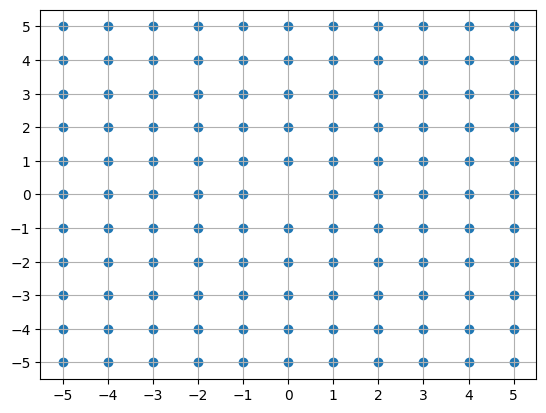

(120, 2)

In [18]:
points = get_grid_offsets(-5, 5)
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.min(points[:,0]), np.max(points[:,0]) + 1, 1))
plt.yticks(range(np.min(points[:,1]), np.max(points[:,1]) + 1, 1))
plt.grid()
plt.show()
points.shape

In [19]:
def get_clock_offsets(radiuses):
    assert np.all(np.array(radiuses) > 0)
    hours = 12
    rotation_transfs = []
    
    for i in range(hours):
        theta = (2 * math.pi / hours) * i
        cos_theta = math.cos(theta)
        sin_theta = math.sin(theta)
        transf = [
            [cos_theta, sin_theta, 0],
            [-sin_theta, cos_theta, 0],
            [0, 0, 1]
        ]
        rotation_transfs.append(np.array(transf))
    
    rotation_transfs = np.array(rotation_transfs)
    points = dict()
    
    for radius in radiuses:
        arrow = np.array([radius, 0, 0])
        arrow_positions = (rotation_transfs @ arrow).astype(int)
        # duplicates handling
        arrow_positions_codes = [''.join(map(str, ap)) for ap in arrow_positions]
        points.update(zip(arrow_positions_codes, arrow_positions))
    
    if '000' in points: 
        del points['000']

    return np.array(list(points.values()))[:,0:2]

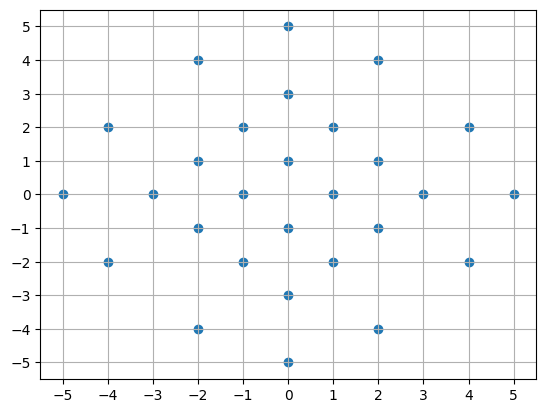

(28, 2)

In [20]:
radiuses = [5, 3, 1]
points = get_clock_offsets(radiuses)
plt.grid()
plt.scatter(points[:,0], points[:,1])
plt.xticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.yticks(range(np.max(radiuses) * -1, np.max(radiuses) + 1, 1))
plt.show()
points.shape

In [21]:
def generate_image_offsets(image, offsets):
    sz = int(np.sqrt(image.shape[0]))
    assert sz * sz == image.shape[0]
    images = []

    for off in offsets:
        image_offed = image.reshape(sz, sz)
        image_offed = np.roll(image_offed, off[0], axis=0)
        rows_to_wipeout = [min(off[0], 0) + i for i in range(abs(off[0]))]
        image_offed[rows_to_wipeout,:] = 0
        image_offed = np.roll(image_offed, off[1], axis=1)
        cols_to_wipeout = [min(off[1], 0) + i for i in range(abs(off[1]))]
        image_offed[:,cols_to_wipeout] = 0
        image_offed = image_offed.reshape(-1)
        images.append(image_offed)

    return np.array(images)

In [22]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))


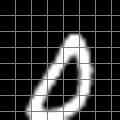
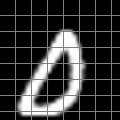
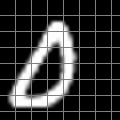
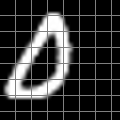
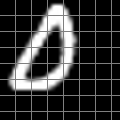
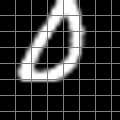
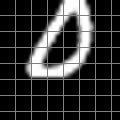
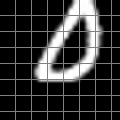
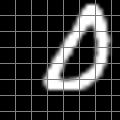
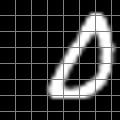
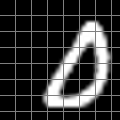
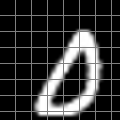
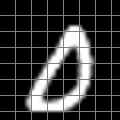
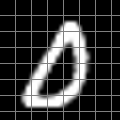
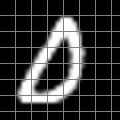
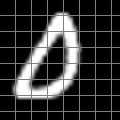
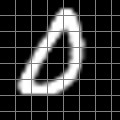
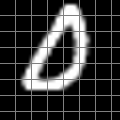
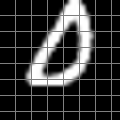
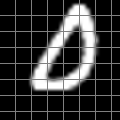
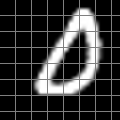
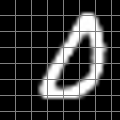
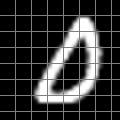
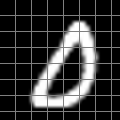
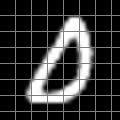
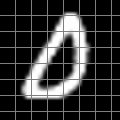
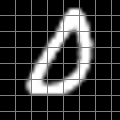
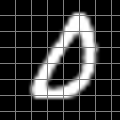

In [23]:
xy_offsets = get_clock_offsets([5, 3, 1])
img_data = x_train[RNG.choice(len(x_train))]

with Image.frombytes('L', size=(28, 28), data=img_data) as img:
    image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)

display_images_grid(list(map(lambda i: lay_grid(matrix_to_image(i).resize((120, 120)), 16), image_offsets)), col_count=8)

In [24]:
id_offset = 0

image_indices = RNG.choice(len(x_train), 100, replace=False)
image_dataset = defaultdict(list)
image_encoding_dataset = defaultdict(list)
xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])

for i in tqdm(image_indices):
    img_data = x_train[i]
    img_label = y_train[i]

    with Image.frombytes('L', size=(28, 28), data=img_data) as img:
        b = io.BytesIO()
        img = img.resize((config.sample_size, config.sample_size))
        img.save(b, format='PNG')
        png = b.getvalue()

        image_id = i + id_offset
        image_dataset['image_id'].append(image_id)
        image_dataset['value'].append(str(img_label))
        image_dataset['png'].append(png)

        image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
        image_offset_encodings = sense_images(xp.array(image_offsets))

        for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
            image_encoding_dataset['image_id'].append(image_id)
            image_encoding_dataset['offset_x'].append(x)
            image_encoding_dataset['offset_y'].append(y)
            image_encoding_dataset['data'].append(ioe.get())

image_dataset = pd.DataFrame(image_dataset)
image_dataset.set_index('image_id')

image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
image_encoding_dataset['encoding_id'] = image_encoding_dataset.index
image_encoding_dataset.set_index(['encoding_id', 'image_id'])
;

  0%|          | 0/100 [00:00<?, ?it/s]

''

In [132]:
def create_datasets(x_dataset, y_dataset, samples_count, id_offset):
    image_indices = RNG.choice(len(x_dataset), samples_count, replace=False)
    image_dataset = defaultdict(list)
    image_encoding_dataset = defaultdict(list)
    xy_offsets = np.concat([[[0, 0]], get_clock_offsets([5, 3, 1])])
    
    for i in tqdm(image_indices):
        img_data = x_dataset[i]
        img_label = y_dataset[i]
    
        with Image.frombytes('L', size=(28, 28), data=img_data) as img:
            b = io.BytesIO()
            img = img.resize((config.sample_size, config.sample_size))
            img.save(b, format='PNG')
            png = b.getvalue()
    
            image_id = i + id_offset
            image_dataset['image_id'].append(image_id)
            image_dataset['value'].append(str(img_label))
            image_dataset['png'].append(png)
    
            image_offsets = generate_image_offsets(np.array(img).ravel(), xy_offsets)
            image_offset_encodings = sense_images(xp.array(image_offsets))
    
            for ioe, (x, y) in zip(image_offset_encodings, xy_offsets):
                image_encoding_dataset['image_id'].append(image_id)
                image_encoding_dataset['offset_x'].append(x)
                image_encoding_dataset['offset_y'].append(y)
                image_encoding_dataset['data'].append(ioe.get())
    
    image_dataset = pd.DataFrame(image_dataset)
    image_dataset.set_index('image_id', inplace=True)

    image_encoding_dataset = pd.DataFrame(image_encoding_dataset)
    image_encoding_dataset['encoding_id'] = image_encoding_dataset.index
    image_encoding_dataset.set_index(['encoding_id', 'image_id'], inplace=True)

    return image_dataset, image_encoding_dataset

def save_datasets(image_dataset, image_encoding_dataset, db_name):
    with sqlite3.connect(os.path.join(config.dataset_path, db_name)) as con:
        image_dataset.to_sql(name='images', con=con)
        image_encoding_dataset.to_sql(name='image_encodings', con=con)

In [134]:
clear_dataset_folder()
image_dataset, image_encoding_dataset = create_datasets(x_train, y_train, config.dataset_train_samples_count, 0)
save_datasets(image_dataset, image_encoding_dataset, 'train.db')

image_dataset, image_encoding_dataset = create_datasets(x_test, y_test, config.dataset_test_samples_count, 100_000_000)
save_datasets(image_dataset, image_encoding_dataset, 'test.db')

In [133]:
save_datasets(image_dataset, image_encoding_dataset, 'test.db')